# Tutorial found here: https://keras.io/examples/vision/video_classification/

In [49]:
import os

import keras
from imutils import paths

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
from IPython.display import Image

In [50]:
IMG_SIZE = 250
BATCH_SIZE = 64
EPOCHS = 8

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [51]:
#base_path = '~/ufc101_top5/'
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 1171
Total videos for testing: 459


,video_name,tag
662,v_PlayingDhol_g20_c02.avi,PlayingDhol
448,v_HorseRiding_g23_c06.avi,HorseRiding
317,v_Drumming_g21_c02.avi,Drumming
881,v_Punch_g17_c06.avi,Punch
726,v_PlayingGuitar_g12_c04.avi,PlayingGuitar
238,v_Drumming_g09_c02.avi,Drumming
708,v_PlayingGuitar_g09_c04.avi,PlayingGuitar
1000,v_ShavingBeard_g18_c02.avi,ShavingBeard
817,v_Punch_g08_c03.avi,Punch
288,v_Drumming_g16_c07.avi,Drumming


One of the many challenges of training video classifiers is figuring out a way to feed the videos to a network. This blog post discusses five such methods. Since a video is an ordered sequence of frames, we could just extract the frames and put them in a 3D tensor. But the number of frames may differ from video to video which would prevent us from stacking them into batches (unless we use padding). As an alternative, we can save video frames at a fixed interval until a maximum frame count is reached. In this example we will do the following:

Capture the frames of a video.
Extract frames from the videos until a maximum frame count is reached.
In the case, where a video's frame count is lesser than the maximum frame count we will pad the video with zeros.
Note that this workflow is identical to problems involving texts sequences. Videos of the UCF101 dataset is known to not contain extreme variations in objects and actions across frames. Because of this, it may be okay to only consider a few frames for the learning task. But this approach may not generalize well to other video classification problems. We will be using OpenCV's VideoCapture() method to read frames from videos.

In [52]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

We can use a pre-trained network to extract meaningful features from the extracted frames. The Keras Applications module provides a number of state-of-the-art models pre-trained on the ImageNet-1k dataset. We will be using the InceptionV3 model for this purpose.

In [53]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

The labels of the videos are strings. Neural networks do not understand string values, so they must be converted to some numerical form before they are fed to the model. Here we will use the StringLookup layer encode the class labels as integers.

In [54]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['BoxingPunchingBag', 'CricketShot', 'Drumming', 'HorseRiding', 'PlayingCello', 'PlayingDhol', 'PlayingGuitar', 'Punch', 'ShavingBeard', 'TennisSwing']


Finally, we can put all the pieces together to create our data processing utility.

In [55]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (1171, 20, 2048)
Frame masks in train set: (1171, 20)


The above code block will take ~20 minutes to execute depending on the machine it's being executed.



# The sequence model
Now, we can feed this data to a sequence model consisting of recurrent layers like GRU.

In [56]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True, use_cudnn=False)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8,use_cudnn=False)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/8
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2566 - loss: 2.0724
Epoch 1: val_loss improved from inf to 2.95299, saving model to /tmp/video_classifier/ckpt.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.2600 - loss: 2.0668 - val_accuracy: 0.0000e+00 - val_loss: 2.9530
Epoch 2/8
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5057 - loss: 1.6173 
Epoch 2: val_loss did not improve from 2.95299
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5079 - loss: 1.6140 - val_accuracy: 0.0000e+00 - val_loss: 3.2454
Epoch 3/8
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5895 - loss: 1.4118
Epoch 3: val_loss did not improve from 2.95299
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5891 - loss: 1.4110 - val_accuracy: 0.0000e+00 - val_loss: 3.5093
Epoch 4/8
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6154 - loss: 1.2789
Epoch 4: val_loss did not improve from 2.95299
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6163 - lo

## Inference

Test video path: v_Drumming_g04_c01.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
  PlayingDhol: 14.18%
  BoxingPunchingBag: 12.55%
  PlayingGuitar: 12.01%
  PlayingCello: 10.22%
  ShavingBeard: 10.10%
  CricketShot:  8.91%
  Drumming:  8.23%


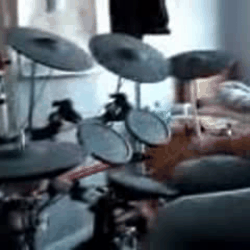

: 

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])